## Introduction

In the following analysis we will explore whether specific apps in the [Google Play Store Apps](https://www.kaggle.com/lava18/google-play-store-apps) dataset are good candidates for increased price value. In other words, we will attempt to find if specific apps are **undervalued** based on specific criteria that we will define. 

Ultimately, the goal is to create a prototype that will allow us to understand if such apps exist and if they do, be more confident that a more in-depth analysis is warranted.

### Summary of Results
After completing the analysis we conclude that there are definitely apps that are undervalued(roughly 55%) and are good candidates for a price increase. 

In order to find the optimal price point, we used the average price of an app's affordability, and for the number of times an app is purchased we used the number of installations as a proxy, as we did not have access to purchase data.

Given the limitations of the dataset we were not able to estimate accurately the impact. Despite that, the major insight is that around 55% of the apps are undervalued, so the recommedation is that a more in-depth analysis is warranted.

As for next steps, recommendations include:
* Getting data for number of purchases.
* A larger volume of overall data can be helpful as the existing dataset was quite small.
* Choose a sample of the existing undervalued apps that we found, increase their price and monitor the response.

In [1]:
import pandas as pd

playstore = pd.read_csv("googleplaystore.csv")
print(playstore.shape)

(10841, 13)


## Explore and Clean the Dataset

### Clean problematic row

In [2]:
# Change the value in the specific cell.
playstore.iloc[10472, 1] = "LIFESTYLE"
print(playstore.iloc[10472, 1])

LIFESTYLE


In [3]:
# Change the value in the specific cell.
playstore.iloc[10472, 9] = "Lifestyle"
print(playstore.iloc[10472, 9])

Lifestyle


In [4]:
# Drop the row.
playstore.drop(labels=10472, inplace=True)

### Change Data Types

In [5]:
playstore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null object
Size              10840 non-null object
Installs          10840 non-null object
Type              10839 non-null object
Price             10840 non-null object
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.2+ MB


We notice that there are some columns which should have numeric format but their type is *object*:
* *Reviews*: Because of the column that we dropped above, the type is object.
* *Size*: The column contains letters like "M" and "k".
* *Price*: Contains values with the "$" symbol.

In the below cells we will clean these columns.

In [6]:
# Clean Price column
playstore["Price"] = playstore["Price"].str.replace("$", "").astype("float")

Now we can focus on the paid only apps.

In [8]:
# Create dataframe with only the paid apps.
paid = playstore[playstore["Price"] != 0].copy()
# Drop the "Type" column.
paid.drop(labels="Type", axis=1, inplace=True)

In [9]:
# Set the type of "Reviews" column to int.
paid["Reviews"] = paid["Reviews"].astype("int")

Next, define a function to clean the "Size" column.

In [10]:
def clean_size(size):
    """Convert file size string to float and megabytes"""
    size = size.replace("M","")
    if size.endswith("k"):
        size = float(size[:-1])/1000
    elif size == "Varies with device":
        size = pd.np.NaN
    else:
        size = float(size)
    return size

# Clean the Size column.
paid["Size"] = paid["Size"].apply(func=clean_size)

In [11]:
# See the results.
paid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 234 to 10798
Data columns (total 12 columns):
App               800 non-null object
Category          800 non-null object
Rating            647 non-null float64
Reviews           800 non-null int64
Size              724 non-null float64
Installs          800 non-null object
Price             800 non-null float64
Content Rating    800 non-null object
Genres            800 non-null object
Last Updated      800 non-null object
Current Ver       798 non-null object
Android Ver       799 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 81.2+ KB


### Remove Duplicates

In [12]:
print(
    "Number of rows before dropping duplicates: {}".format(paid.shape[0])
)
paid.drop_duplicates(inplace=True)
print(
    "Number of rows after dropping duplicates: {}".format(paid.shape[0])
)

Number of rows before dropping duplicates: 800
Number of rows after dropping duplicates: 765


In [13]:
# Using the "App" column as the criterion for the duplicates
print(paid.duplicated(subset="App").sum())

9


The duplicated exist for because of two reasons:
* Category differs
* Reviews differ

In [15]:
# Cleaning problematic apps(Category)
app_filter = paid["App"].isin(
    ["Fuzzy Numbers: Pre-K Number Foundation", "Toca Life: City"]
)

category_filter = paid["Category"] == "FAMILY"

paid[app_filter & category_filter]

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2151,Toca Life: City,FAMILY,4.7,31100,24.0,"500,000+",3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up
4301,Fuzzy Numbers: Pre-K Number Foundation,FAMILY,4.7,21,44.0,"1,000+",5.99,Everyone,Education;Education,"July 21, 2017",1.3,4.1 and up


In [16]:
# Drop problematic apps(Category)
paid.drop([2151, 4301], inplace=True)

Next, we clean duplicate rows where the number of reviews is not the highest.

In [17]:
# Sort paid dataframe by the number of reviews.
paid.sort_values(by="Reviews", ascending=False, inplace=True)

# Drop duplicates in the Reviews column except for the first instance.
paid.drop_duplicates("App", inplace=True)
paid.duplicated("App").sum()

paid.reset_index(inplace=True, drop=True)

### Explore the Price

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bc8c2b0>]],
      dtype=object)

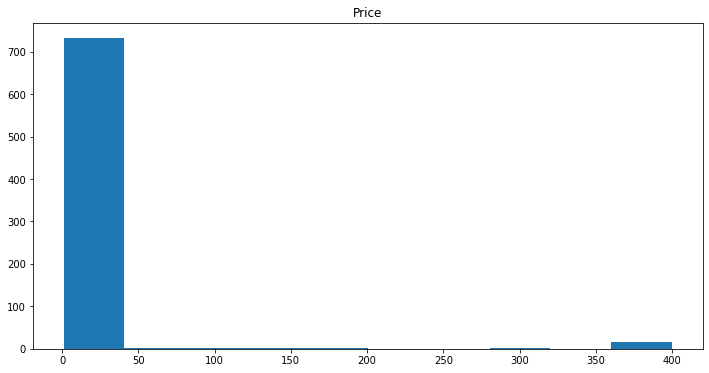

In [20]:
# Plot the distribution
%matplotlib inline
paid.hist(column="Price", grid=False, figsize=(12,6))

The distribution is skewed to the left and there are a few outliers to the right - apps with very high price.

In [21]:
paid.sort_values(by="Price", ascending=False).head(5)

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
277,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.3,"10,000+",400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
207,I am Rich Plus,FAMILY,4.0,856,8.7,"10,000+",399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
355,I am rich (Most expensive app),FINANCE,4.1,129,2.7,"1,000+",399.99,Teen,Finance,"December 6, 2017",2,4.0.3 and up
371,I am Rich!,FINANCE,3.8,93,22.0,"1,000+",399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
155,I Am Rich Premium,FINANCE,4.1,1867,4.7,"50,000+",399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up


We see that these apps are very expensive compared to the others and do not add any value to the analysis, on the contrary they create problems. For that reason we exclude them from further analysis and keep only the apps that have a price below $50.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d154278>]],
      dtype=object)

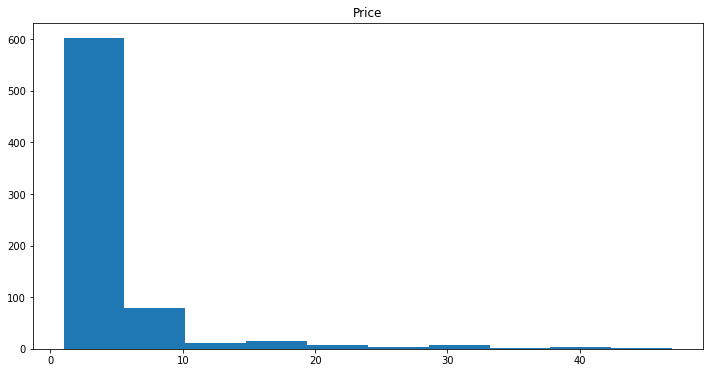

In [22]:
affordable_apps = paid[paid["Price"]<50].copy()
affordable_apps.hist(column="Price", grid=False, figsize=(12,6))

Despite excluding those columns we see that the data is still skewed. The majority of the apps cost less than $5. We will explore this further.

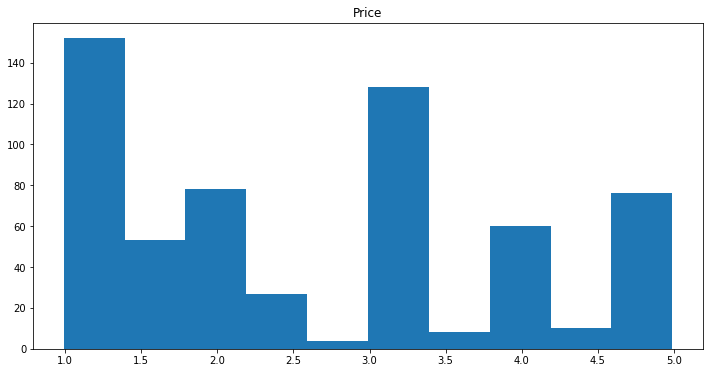

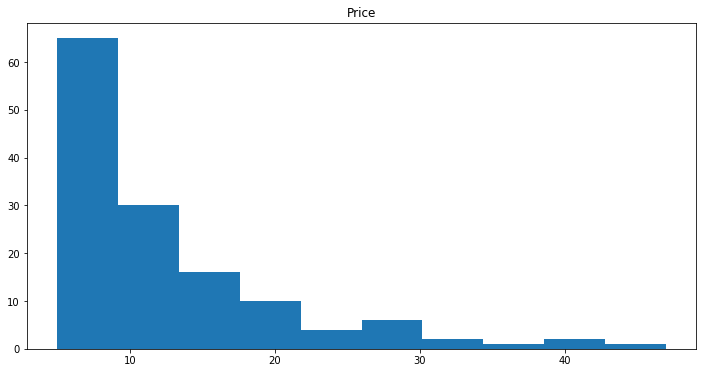

In [23]:
# Create dataframe of apps that cost less than $5. 
cheap = affordable_apps["Price"] < 5

# Create dataframe of apps that cost $5 or more.
reasonable = affordable_apps["Price"] >= 5

# Create histogram of apps that cost less than $5.
affordable_apps[cheap].hist(column="Price", grid=False, figsize=(12,6))

# Create histogram of apps that cost $5 or more.
affordable_apps[reasonable].hist(column="Price", grid=False, figsize=(12,6))

# Create column in affordable_apps with "cheap" and "reasonable" as groups.
affordable_apps["affordability"] = affordable_apps.apply(
    lambda row: "cheap" if row["Price"] < 5 else "reasonable",
    axis=1
)

We notice that the "reasonable" priced apps are still skewed to the left. It's good to keep that in mind during our analysis.

### Explore the relationship between Price and other columns

**Rating**

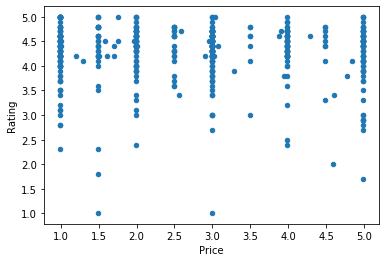

In [24]:
affordable_apps[cheap].plot(kind="scatter", x="Price", y="Rating")

In [25]:
# Correlation between Price and Rating
print(affordable_apps[cheap].corr().loc["Rating", "Price"])

-0.05593771505463038


It seems that there is no notable relationship between the two. Based on that we can assume that it is safe to change prices without this being reflected to the ratings.

One approach can be to increase the price of the apps that cost less than the average price for the cheaper apps, to match that price.

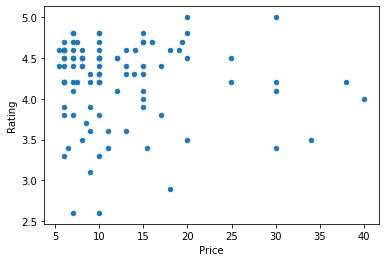

In [26]:
# Find mean price of cheap apps(column affordability).
cheap_mean = affordable_apps.loc[cheap, "Price"].mean()

# Create column price_criterion based on value of cheap_mean.
affordable_apps.loc[cheap, "price_criterion"] = affordable_apps["Price"].apply(
    lambda price: 1 if price < cheap_mean else 0
)

# Create scatterplot for reasonable apps.
affordable_apps[reasonable].plot(kind="scatter", x="Price", y="Rating")

# Find mean price of reasonable apps(column affordability).
reasonable_mean = affordable_apps.loc[reasonable, "Price"].mean()

# Create column price_criterion based on value of cheap_mean.
affordable_apps.loc[reasonable,"price_criterion"] = affordable_apps["Price"].apply(
    lambda price: 1 if price < reasonable_mean else 0
)

**Category & Genre**

* *Genre*:
    * Looking at the genre column in the first few rows we notice that a lot of apps belong to more than one genre, separated by the ";" character.

In [27]:
print(affordable_apps["Genres"].unique())

['Arcade;Action & Adventure' 'Action' 'Strategy' 'Puzzle;Brain Games'
 'Card;Action & Adventure' 'Sports' 'Personalization' 'Arcade' 'Puzzle'
 'Productivity' 'Weather' 'Tools' 'Sports;Action & Adventure'
 'Communication' 'Role Playing' 'Photography' 'Card'
 'Simulation;Education' 'Adventure' 'Education;Pretend Play' 'Lifestyle'
 'Strategy;Action & Adventure' 'Board' 'Finance' 'Health & Fitness'
 'Role Playing;Action & Adventure' 'Music' 'Travel & Local' 'Business'
 'Simulation' 'Adventure;Action & Adventure' 'Parenting'
 'Adventure;Brain Games' 'Entertainment' 'Maps & Navigation'
 'Video Players & Editors' 'Racing' 'Medical' 'Auto & Vehicles'
 'Educational;Pretend Play' 'Casual;Pretend Play' 'Education;Creativity'
 'Education' 'Board;Brain Games' 'Food & Drink'
 'Action;Action & Adventure' 'Simulation;Pretend Play' 'Dating'
 'Books & Reference' 'Art & Design' 'Racing;Action & Adventure' 'Casual'
 'Education;Education' 'Educational;Education' 'Casual;Education'
 'Shopping' 'Books & Refe

Looking at all the possible values of the column, we see that ";" is not part of the name of any app. The next step is to create a column that counts the number of genres an app belongs.

In [28]:
affordable_apps["genre_count"] = affordable_apps["Genres"].str.count(";")+1

Now we can see how the average price varies across the number of genres.

In [29]:
genres_mean = affordable_apps.groupby(
    ["affordability", "genre_count"]
).mean()[["Price"]]
genres_mean

Price
affordability genre_count           
cheap         1             2.507448
              2             3.155672
reasonable    1            12.574627
              2             6.823333

It's interesting to notice that apps that belong to two genres are more expensive among the cheap apps and cheaper among the reasonable apps.

For each segment, let's label the apps that cost less than their corresponding segments' mean with 1, and the others with 0:

In [30]:
def label_genres(row):
    """For each segment in `genres_mean`,
    labels the apps that cost less than its segment's mean with `1`
    and the others with `0`."""

    aff = row["affordability"]
    gc = row["genre_count"]
    price = row["Price"]

    if price < genres_mean.loc[(aff, gc)][0]:
        return 1
    else:
        return 0

affordable_apps["genre_criterion"] = affordable_apps.apply(
    label_genres, axis="columns"
)

Next, we will do the same for the *Category* column as we did with the *Genre* above

In [31]:
# Find how the mean price varies across the number of categories(mean price for each segment).
categories_mean = affordable_apps.groupby(
    ["affordability", "Category"]
).mean()[["Price"]]

# Label the apps that cost less than their corresponding segments(category) mean.
def label_categories(row):
     aff = row["affordability"]
     cat = row["Category"]
     price = row["Price"]

     if price < categories_mean.loc[(aff, cat)][0]:
        return 1
     else:
        return 0
    
affordable_apps["category_criterion"] = affordable_apps.apply(
    label_categories, axis="columns"
)

## Assessing if a pricing increase is a viable option

With the work done above, we now have 3 criteria that we can use to decide if an app's price should increase. In order to use all 3 we can use the **majority voting** technique.

In [32]:
criteria = ["price_criterion", "genre_criterion", "category_criterion"]
affordable_apps["Result"] = affordable_apps[criteria].mode(axis='columns')

affordable_apps.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,affordability,price_criterion,genre_count,genre_criterion,category_criterion,Result
492,Dr. Splorchy Presents Space Heroes,GAME,4.6,18,31.0,100+,4.99,Mature 17+,Adventure,"July 23, 2018",1.0,7.0 and up,cheap,0.0,1,0,0,0.0
302,The Secret Daily Teachings,LIFESTYLE,4.3,206,32.0,"1,000+",4.99,Everyone,Lifestyle,"February 11, 2018",14.0,4.0.3 and up,cheap,0.0,1,0,0,0.0
540,Bo's School Day,FAMILY,4.7,10,30.0,"1,000+",2.99,Everyone,Education;Pretend Play,"December 18, 2017",1.3,4.0.3 and up,cheap,0.0,2,1,0,0.0
500,K.MOJI,FAMILY,4.8,16,8.9,500+,1.99,Everyone,Entertainment,"May 9, 2017",1.0,4.2 and up,cheap,1.0,1,1,1,1.0
396,"10,000 Quotes DB (Premium)",BOOKS_AND_REFERENCE,4.1,70,3.5,500+,0.99,Everyone,Books & Reference,"August 30, 2013",1.3,2.1 and up,cheap,1.0,1,1,1,1.0


In [33]:
# See how many apps would be candidates for price increase.
nr_eligible = affordable_apps["Result"].sum()
print(nr_eligible, nr_eligible/affordable_apps.shape[0], sep="\n")

401.0
0.5470668485675307


In [34]:
# We already computed cheap_mean and reasonable_mean.
# Create new column in affordable_apps that is the maximum between Price and cheap_mean for the cheap apps, and the maximum between Price and reasonable_mean for the reasonable apps.
def new_price(row):
    if row["affordability"] == "cheap":
        return round(max(row["Price"], cheap_mean), 2)
    else:
        return round(max(row["Price"], reasonable_mean), 2)
    
affordable_apps["New Price"] = affordable_apps.apply(new_price, axis="columns")

# Clean and transform Installs into a numeric column.
affordable_apps["Installs"] = affordable_apps["Installs"].str.replace("[+,]", "").astype(int)

# Calculate the impact of each app and create new column "Impact".
affordable_apps["Impact"] = (affordable_apps["New Price"]-affordable_apps["Price"])*affordable_apps["Installs"]

# Calculate and print total_impact.
total_impact = affordable_apps["Impact"].sum()
print(total_impact) 

115441618.98


## Conclusion

It seems that the estimated impact is too big to be realistic, so there is a high probability that our data was lacking or we have to take another approach sing other columns/variables, to try and get a more realistic estimate.